# ChurnInsight — Modelagem de Churn com **CatBoost** (Telco Customer Churn)

Este notebook replica o fluxo do seu material de referência (ingestão via **kagglehub**, limpeza, EDA e modelagem),
substituindo o algoritmo **Random Forest** por **CatBoostClassifier** (Gradient Boosting de árvores com suporte nativo a variáveis categóricas).

**Dataset:** *Telco Customer Churn* (Kaggle: `blastchar/telco-customer-churn`)


## 1) Importação de bibliotecas

In [6]:
%pip install matplotlib seaborn scikit-learn catboost kagglehub[pandas-datasets]


  Using cached catboost-1.2.8-cp313-cp313-win_amd64.whl.metadata (1.5 kB)
  Using cached scipy-1.17.0-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
  Using cached plotly-6.5.1-py3-none-any.whl.metadata (8.5 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 8.0/8.0 MB 53.4 MB/s eta 0:00:00
Using cached catboost-1.2.8-cp313-cp313-win_amd64.whl (102.4 MB)
Using cached scipy-1.17.0-cp313-cp313-win_amd64.whl (36.3 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Using cached graphviz-0.21-py3-none-any.whl (47 kB)
Using cached plotly-6.5.1-py3-none-any.whl (9.9 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2) Importação do Dataset (kagglehub)

In [5]:
 #Install dependencies as needed:
 %pip install kagglehub[pandas-datasets]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    RocCurveDisplay
)

# CatBoost (se estiver no Colab, descomente a linha abaixo)
# !pip -q install catboost

from catboost import CatBoostClassifier, Pool


In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Observação:
# - kagglehub.load_dataset() pode emitir DeprecationWarning em versões novas.
# - Para manter compatibilidade, tentamos usar dataset_load() se existir; caso contrário, usamos load_dataset().
if hasattr(kagglehub, "dataset_load"):
    df = kagglehub.dataset_load(
        KaggleDatasetAdapter.PANDAS,
        "blastchar/telco-customer-churn",
        file_path,
    )
else:
    df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "blastchar/telco-customer-churn",
        file_path,
    )

print("First 5 records:")
display(df.head())
print("\nShape:", df.shape)


c:\Users\USER\Documents\Repositorios\churninsight-nocountry-clean\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 955k/955k [00:00<00:00, 1.16MB/s]

First 5 records:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Shape: (7043, 21)


## 3) Estrutura inicial e tipos (dtypes/info)

In [3]:
display(df.head())
display(df.dtypes)

df.info()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 4) Tratamento do dataset

In [4]:
# Conversão da coluna TotalCharges de object -> numérico
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Ver valores únicos das colunas object (categóricas)
for col in df.select_dtypes(include="object").columns:
    print(col, df[col].unique())


customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


In [5]:
# Tratando valores vazios e nulos
print("Nulos por coluna (antes):")
display(df.isnull().sum())

df = df.dropna().copy()

print("Nulos por coluna (depois):")
display(df.isnull().sum())

display(df.head())
print("Shape (após dropna):", df.shape)


Nulos por coluna (antes):


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Nulos por coluna (depois):


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Shape (após dropna): (7032, 21)


## 5) Análise exploratória (EDA) — exemplos do seu fluxo

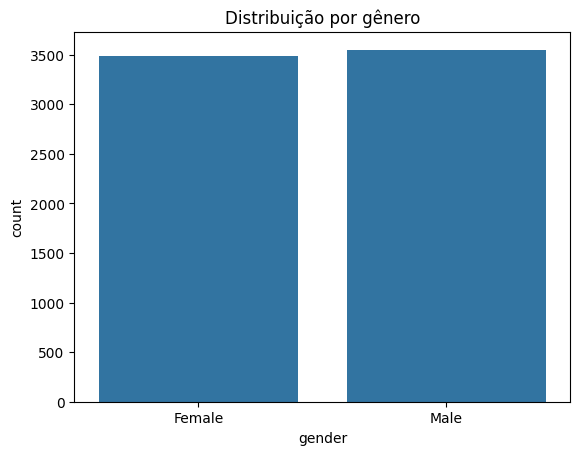

In [6]:
sns.countplot(x="gender", data=df)
plt.title("Distribuição por gênero")
plt.show()


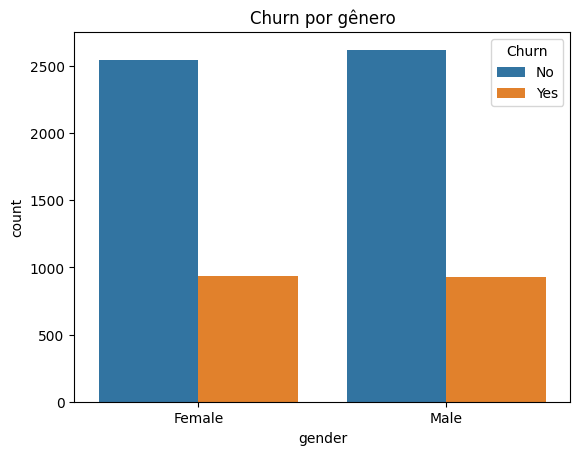

Proporção de churn por gênero:


Churn,No,Yes
gender,,
Female,0.730405,0.269595
Male,0.737954,0.262046


In [7]:
sns.countplot(x="gender", hue="Churn", data=df)
plt.title("Churn por gênero")
plt.show()

# Proporção de churn por gênero
proporcao = df.groupby("gender")["Churn"].value_counts(normalize=True).unstack()
print("Proporção de churn por gênero:")
display(proporcao)


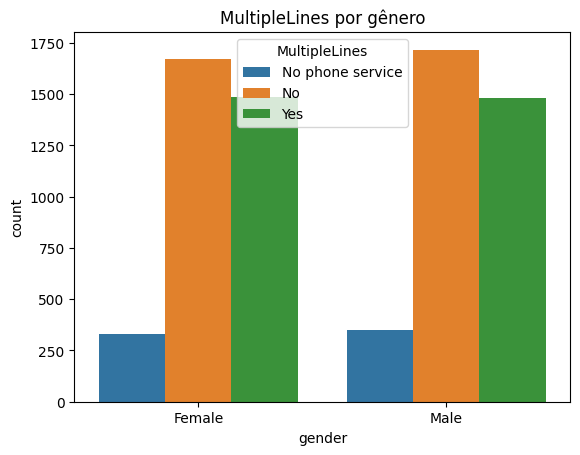

Proporção de MultipleLines por gênero:


MultipleLines,No,No phone service,Yes
gender,,,
Female,0.479185,0.094459,0.426357
Male,0.483516,0.098901,0.417582


In [8]:
sns.countplot(x="gender", hue="MultipleLines", data=df)
plt.title("MultipleLines por gênero")
plt.show()

proporcao = df.groupby("gender")["MultipleLines"].value_counts(normalize=True).unstack()
print("Proporção de MultipleLines por gênero:")
display(proporcao)


## 6) Preparação do alvo (Churn)

C:\Users\USER\AppData\Local\Temp\ipykernel_46736\3837333634.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0}).infer_objects(copy=False)


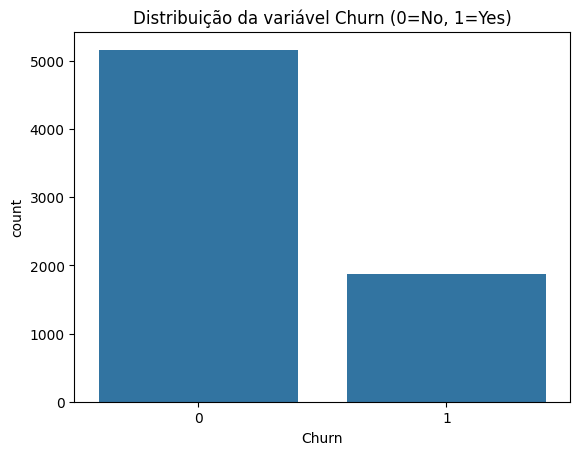

Proporção de Churn:


Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64

In [9]:
# Converter coluna alvo 'Churn' para binária (Yes=1, No=0)
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0}).infer_objects(copy=False)

sns.countplot(x="Churn", data=df)
plt.title("Distribuição da variável Churn (0=No, 1=Yes)")
plt.show()

print("Proporção de Churn:")
display(df["Churn"].value_counts(normalize=True))


## 7) EDA adicional (mantendo a linha do seu material)

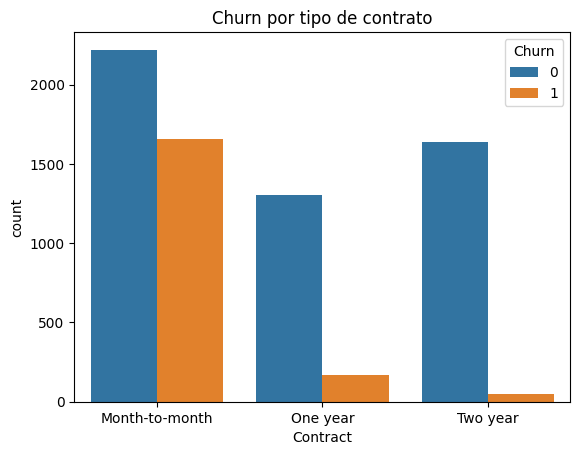

In [10]:
sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Churn por tipo de contrato")
plt.show()


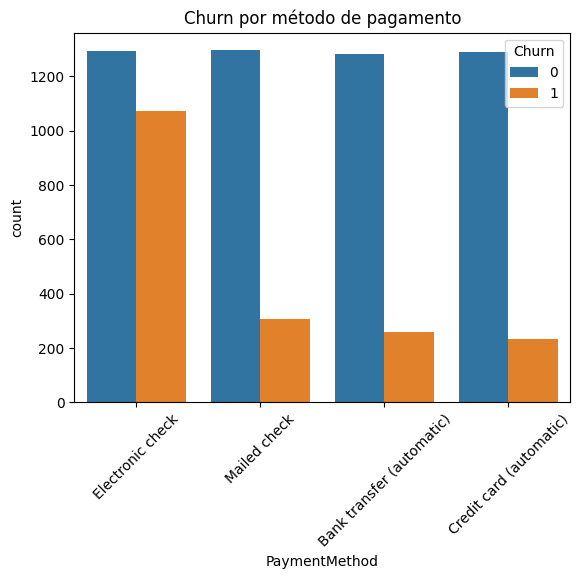

In [11]:
sns.countplot(x="PaymentMethod", hue="Churn", data=df)
plt.xticks(rotation=45)
plt.title("Churn por método de pagamento")
plt.show()


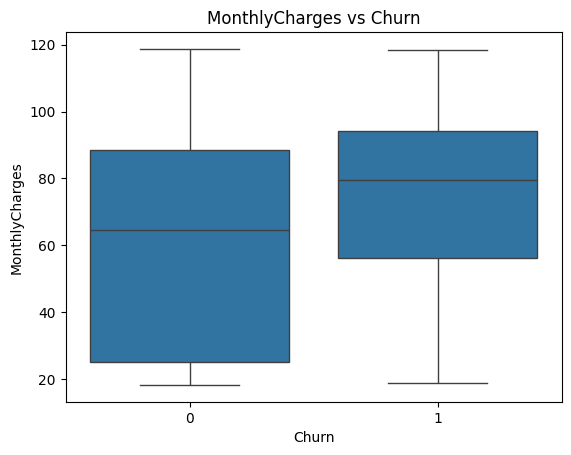

In [12]:
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("MonthlyCharges vs Churn")
plt.show()


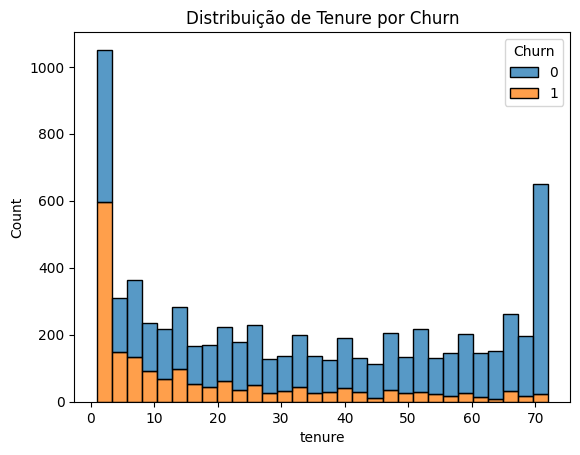

In [13]:
sns.histplot(data=df, x="tenure", hue="Churn", multiple="stack", bins=30)
plt.title("Distribuição de Tenure por Churn")
plt.show()


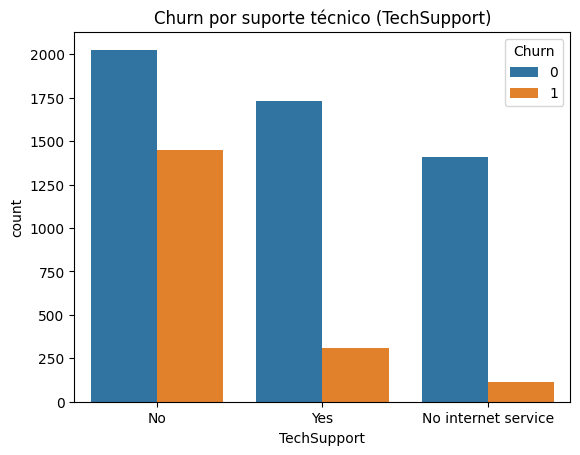

In [14]:
sns.countplot(x="TechSupport", hue="Churn", data=df)
plt.title("Churn por suporte técnico (TechSupport)")
plt.show()


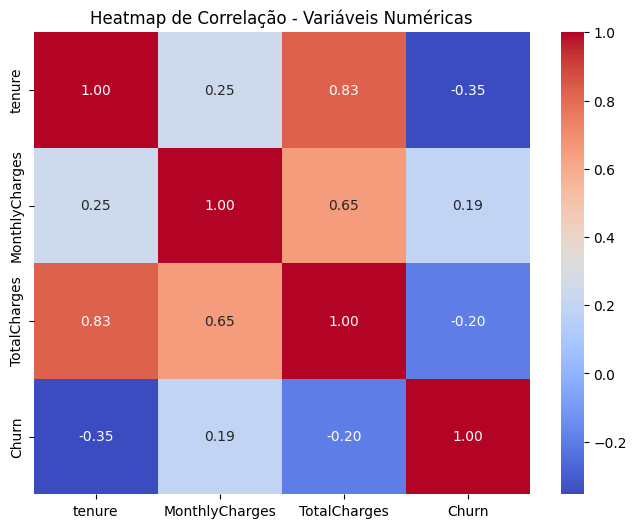

In [15]:
numericas = ["tenure", "MonthlyCharges", "TotalCharges", "Churn"]
corr = df[numericas].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap de Correlação - Variáveis Numéricas")
plt.show()


## 8) Modelagem com CatBoost (sem One-Hot; categorias nativas)

### Por que não usar One-Hot aqui?

O **CatBoost** lida com variáveis categóricas **nativamente** (strings/categorias), reduzindo a necessidade de engenharia manual
e preservando a interpretabilidade (as features continuam com os nomes originais).


In [16]:
# Define features (X) e target (y)
X = df.drop(["customerID", "Churn"], axis=1)
y = df["Churn"]

# Identificar colunas categóricas e numéricas (como no seu fluxo)
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categóricas:", categorical_cols)
print("Numéricas:", numerical_cols)
print("Total de features:", X.shape[1])


Categóricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Total de features: 19


In [17]:
# Split com estratificação para manter a proporção de churn
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Treino:", X_train.shape, "Teste:", X_test.shape)
print("Distribuição y_train:")
display(y_train.value_counts(normalize=True))


Treino: (5625, 19) Teste: (1407, 19)
Distribuição y_train:


Churn
0    0.734222
1    0.265778
Name: proportion, dtype: float64

In [18]:
# Índices das features categóricas (CatBoost recebe índices ou nomes)
cat_features_idx = [X.columns.get_loc(col) for col in categorical_cols]
print("cat_features_idx:", cat_features_idx)


cat_features_idx: [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [21]:
# Pools (estrutura otimizada do CatBoost)
train_pool = Pool(X_train, y_train, cat_features=cat_features_idx)
test_pool = Pool(X_test, y_test, cat_features=cat_features_idx)


In [22]:
# Class weights para lidar com desbalanceamento (classe 1 = churn)
counts = y_train.value_counts()
w0 = 1.0
w1 = (counts[0] / counts[1]) if 1 in counts else 1.0
class_weights = [w0, float(w1)]

print("Class weights:", class_weights)


Class weights: [1.0, 2.762541806020067]


In [23]:
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)
print(categorical_cols[:5], len(categorical_cols))

# Modelo CatBoost
cb = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="Recall",
    random_seed=42,
    class_weights=class_weights,
    verbose=200,
    early_stopping_rounds=50
)

# se X_train/X_test são DataFrames
cat_features = categorical_cols  # ou lista de nomes das colunas categóricas

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)


cb.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True
)




<class 'pandas.core.frame.DataFrame'> (5625, 19)
<class 'pandas.core.series.Series'> (5625,)
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines'] 15
0:	learn: 0.7632107	test: 0.7540107	best: 0.7540107 (0)	total: 200ms	remaining: 6m 40s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8181818182
bestIteration = 8

Shrink model to first 9 iterations.


## 9) Avaliação do modelo

In [24]:
# Previsões
y_pred = cb.predict(X_test)
y_proba = cb.predict_proba(X_test)[:, 1]

print("\n=======================================================")
print("           🎯 PERFORMANCE DO MODELO (CatBoost)")
print("=======================================================")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test, y_proba):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:\n", cm)



           🎯 PERFORMANCE DO MODELO (CatBoost)
Acurácia: 0.7164
ROC AUC : 0.8229

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1033
           1       0.48      0.82      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.69      1407
weighted avg       0.80      0.72      0.73      1407

Matriz de Confusão:
 [[702 331]
 [ 68 306]]


[0.32528664 0.61632207 0.23471356 0.50016447 0.37588586]
(1407,) (1407,)


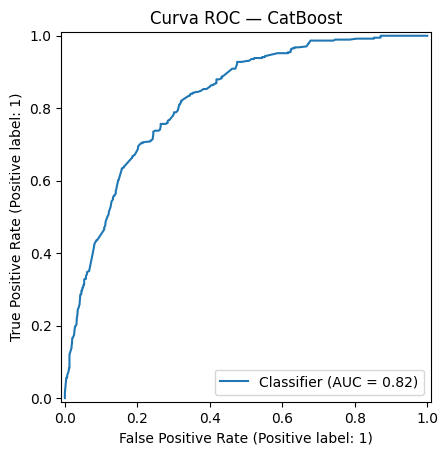

In [26]:
# depois do fit
y_proba = cb.predict_proba(X_test)[:, 1]  # ou use test_pool
print(y_proba[:5])
print(y_proba.shape, y_test.shape)


# Curva ROC
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Curva ROC — CatBoost")
plt.show()


## 10) Importância das variáveis (Feature Importance)

,feature,importance
14,Contract,38.663299
17,MonthlyCharges,25.258622
4,tenure,11.786682
13,StreamingMovies,11.006984
18,TotalCharges,9.391652
7,InternetService,2.834858
15,PaperlessBilling,1.057902
2,Partner,0.000000
1,SeniorCitizen,0.000000
0,gender,0.000000


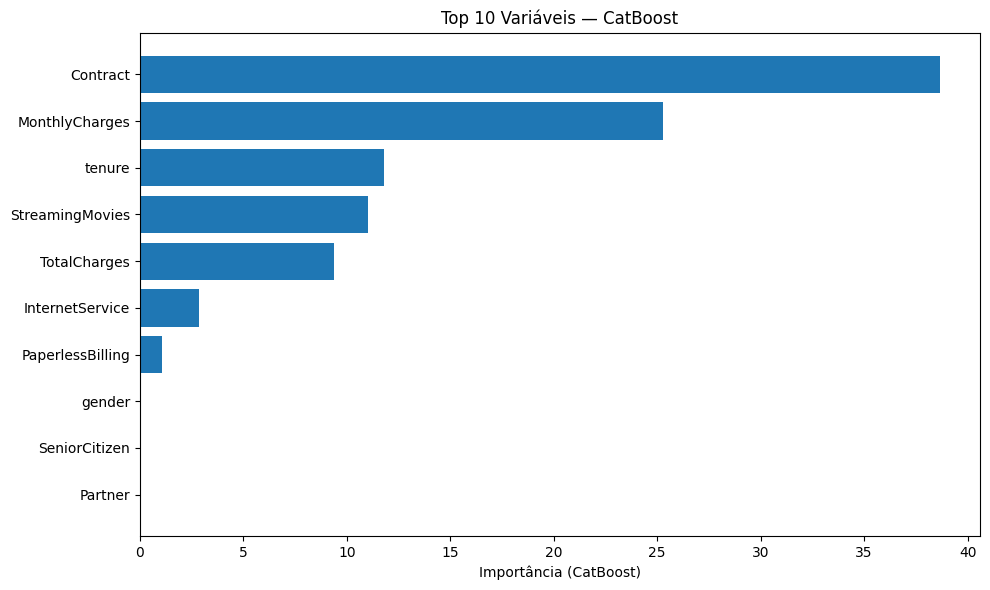

In [27]:
# Importância de features (quanto maior, mais relevante)
importancias = cb.get_feature_importance(train_pool)
feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": importancias
}).sort_values("importance", ascending=False)

display(feat_imp.head(15))

top_n = 10
top = feat_imp.head(top_n).sort_values("importance", ascending=True)

plt.figure(figsize=(10, 6))
plt.title(f"Top {top_n} Variáveis — CatBoost")
plt.barh(top["feature"], top["importance"])
plt.xlabel("Importância (CatBoost)")
plt.tight_layout()
plt.show()


## 11) Serialização / Handoff (modelo + contrato de dados)

In [28]:
import joblib

# 1) Salvar o modelo no formato nativo do CatBoost (recomendado)
cb.save_model("modelo_churn_catboost.cbm")

# 2) Pacote com metadados para facilitar integração no back-end
pacote_final = {
    "model_type": "catboost",
    "model_path": "modelo_churn_catboost.cbm",
    "features": X.columns.tolist(),
    "categorical_cols": categorical_cols,
    "numerical_cols": numerical_cols,
    "cat_features_idx": cat_features_idx
}

joblib.dump(pacote_final, "modelo_churn_catboost_meta.pkl")

print("✅ ARQUIVOS GERADOS:")
print("- modelo_churn_catboost.cbm")
print("- modelo_churn_catboost_meta.pkl")
print("\n--- 📝 MANUAL PARA O BACK-END (Campos do JSON) ---")
print("A API deve receber exatamente estes campos (sem customerID e sem Churn):")
for col in X.columns.tolist():
    print(f"- {col}")


✅ ARQUIVOS GERADOS:
- modelo_churn_catboost.cbm
- modelo_churn_catboost_meta.pkl

--- 📝 MANUAL PARA O BACK-END (Campos do JSON) ---
A API deve receber exatamente estes campos (sem customerID e sem Churn):
- gender
- SeniorCitizen
- Partner
- Dependents
- tenure
- PhoneService
- MultipleLines
- InternetService
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport
- StreamingTV
- StreamingMovies
- Contract
- PaperlessBilling
- PaymentMethod
- MonthlyCharges
- TotalCharges


## 12) Exemplo de API (FastAPI) — usando CatBoost

In [29]:
# Exemplo de integração (referência)
# --------------------------------
# from fastapi import FastAPI
# import pandas as pd
# from pydantic import BaseModel
# from catboost import CatBoostClassifier
#
# app = FastAPI()
#
# model = CatBoostClassifier()
# model.load_model("modelo_churn_catboost.cbm")
#
# class Cliente(BaseModel):
#     gender: str
#     SeniorCitizen: int
#     Partner: str
#     Dependents: str
#     tenure: int
#     PhoneService: str
#     MultipleLines: str
#     InternetService: str
#     OnlineSecurity: str
#     OnlineBackup: str
#     DeviceProtection: str
#     TechSupport: str
#     StreamingTV: str
#     StreamingMovies: str
#     Contract: str
#     PaperlessBilling: str
#     PaymentMethod: str
#     MonthlyCharges: float
#     TotalCharges: float
#
# @app.post("/predict")
# def predict_churn(cliente: Cliente):
#     df_input = pd.DataFrame([cliente.dict()])
#     pred = int(model.predict(df_input)[0])
#     proba = float(model.predict_proba(df_input)[0][1])
#     return {
#         "churn": pred,
#         "probabilidade_churn": round(proba, 4),
#         "mensagem": "Risco de Churn detectado!" if pred == 1 else "Cliente estável."
#     }


## 13) (Opcional) Tuning rápido com `grid_search` do CatBoost

In [31]:
# Grid reduzido para ser rápido.
# O grid_search do CatBoost opera sobre Pools.
# Você pode ajustar os valores conforme seu ambiente.

param_grid = {
    "depth": [4, 6],
    "learning_rate": [0.03, 0.1],
    "l2_leaf_reg": [1, 3]
}

cb_tuned = CatBoostClassifier(
    iterations=800,
    loss_function="Logloss",
    eval_metric="Recall",
    random_seed=42,
    class_weights=class_weights,
    verbose=0
)

grid_result = cb_tuned.grid_search(
    param_grid,
    train_pool,
    cv=3,
    stratified=True,
    shuffle=True,
    partition_random_seed=42,
    verbose=True
)




bestTest = 0.8949275362
bestIteration = 0

0:	loss: 0.8949275	best: 0.8949275 (0)	total: 24.8s	remaining: 2m 53s

bestTest = 0.8949275362
bestIteration = 0

1:	loss: 0.8949275	best: 0.8949275 (0)	total: 49.5s	remaining: 2m 28s

bestTest = 0.8949275362
bestIteration = 0

2:	loss: 0.8949275	best: 0.8949275 (0)	total: 1m 13s	remaining: 2m 2s

bestTest = 0.8949275362
bestIteration = 0

3:	loss: 0.8949275	best: 0.8949275 (0)	total: 1m 38s	remaining: 1m 38s

bestTest = 0.8514492754
bestIteration = 1

4:	loss: 0.8514493	best: 0.8949275 (0)	total: 2m 13s	remaining: 1m 20s

bestTest = 0.8550724638
bestIteration = 5

5:	loss: 0.8550725	best: 0.8949275 (0)	total: 2m 50s	remaining: 56.7s

bestTest = 0.8586956522
bestIteration = 6

6:	loss: 0.8586957	best: 0.8949275 (0)	total: 3m 25s	remaining: 29.3s

bestTest = 0.8514492754
bestIteration = 1

7:	loss: 0.8514493	best: 0.8949275 (0)	total: 4m 1s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.8957915832
bestIteration

In [33]:
# Treinar com melhores parâmetros (se quiser)
best_params = grid_result["params"]

cb_best = CatBoostClassifier(
    iterations=3000,
    loss_function="Logloss",
    eval_metric="Recall",
    random_seed=42,
    class_weights=class_weights,
    early_stopping_rounds=50,
    verbose=200,
    **best_params
)

cb_best.fit(train_pool, eval_set=test_pool, use_best_model=True)

y_pred_best = cb_best.predict(X_test)
y_proba_best = cb_best.predict_proba(X_test)[:, 1]

print("\n=======================================================")
print("      🎯 PERFORMANCE DO MODELO TUNADO (CatBoost)")
print("=======================================================")
print(f"Acurácia: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test, y_proba_best):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_best))

cb_best.save_model("modelo_churn_catboost_tuned.cbm")
print("📦 ARQUIVO SERIALIZADO: modelo_churn_catboost_tuned.joblib")


0:	learn: 0.8046823	test: 0.8048128	best: 0.8048128 (0)	total: 27.5ms	remaining: 1m 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8502673797
bestIteration = 10

Shrink model to first 11 iterations.

      🎯 PERFORMANCE DO MODELO TUNADO (CatBoost)
Acurácia: 0.6780
ROC AUC : 0.8155

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.62      0.74      1033
           1       0.44      0.85      0.58       374

    accuracy                           0.68      1407
   macro avg       0.68      0.73      0.66      1407
weighted avg       0.79      0.68      0.70      1407

📦 ARQUIVO SERIALIZADO: modelo_churn_catboost_tuned.joblib
